# **Analysis Hotel Booking Demand**

### Importing libraries and dataset

In [1]:
# We import some custom functions
from custom_functions import *

# We import classical libraries
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from hyperopt import fmin, tpe, hp, Trials
import pickle

In [2]:
df_original = pd.read_csv('hotel_bookings.csv')

# Exploratory Data Analysis I (EDA I)

In [3]:
value_counts_csv(df_original)
count_nulls(df_original)
hist_boxplot(df_original)

In [4]:
# Number of rows and columns
df_original.shape

(119390, 32)

## - First Remarks and ideas for each column

- **hotel**: 2 classes, 66% City Hotel, 33% Resort Hotel
- **is_canceled** (target_label): 2 values, 0 (62%) or 1 (38%). It is quite unbalanced
- **lead_time**: many values, grouping by new categories? Skewed distributions towards the 0 value
- **arrival_date_year**: 3 years, 2015, 2016 and 2017
- **arrival_date_month**: many arrivals in June and July, it makes sense
- **arrival_date_week_number**: probably we can combine it with arrival_date_month. It has a quite normal distribution
- **arrival_date_day_of_month**: considering we have week_number and month_number we can eliminate this label
- **stays_in_weekend_nights**: skewed distribution towards 0, we could eliminate some big values
- **stays_in_week_nights**: same thought of previous label
- **adults**: 2 is 75% and 1 is 19%, there are some values with 0
- **children**: 93% has 0 children, we can think of eliminate this label or consider to create only a binary class, 4 **null** values
- **babies**: 99% has 0 babies, same thought of children
- **meal**: 3 relevant classes, BB 77%, HB 12% and SC 8%
- **country**: 6 relevant classes, PRT 41%, GBR 10%, FRA 9%, ESP 7%, DEU 6%, ITA 3%, 0.4% of **null** values
- **market_segment**: 5 relevant classes, Online TA 47%, Offline TA/TO 20%, Groups 17%, Direct 10% and Corporate 4.4%
- <span style='color:Orange'> **distribution_channel** </span>: 3 relevant classes TA/TO 82%, Direct 12% and Corporate 5%
- <span style='color:Orange'> **is_repeated_guest** </span>: the clients are quite new, 0 is 97% and 1 is 3%
- <span style='color:Orange'> **previous_cancellations** </span>: two relevant classes, 0 is about 95% and 1 is about 5%. We could transform this into a binary label
- <span style='color:Orange'> **previous_bookings_not_canceled** </span>: it is not relevant since we have previous cancellations.
- <span style='color:Orange'> **reserved_room_type** </span>: 4 relevant classes, A is 72%, D is 16%, E is 5%, F is 2.4 %
- <span style='color:Orange'> **assigned_room_type** </span>: 3 relevant classes, A is 62%, B 21% and E 6%. It could be interesting to know when the customer knows the **assigned_room_type**. If they knew this online some time before, it could be a reason for cancellation
- <span style='color:Orange'> **booking_changes** </span>: distribution is skewed towards 0, 3 relevant classes, 0 is 85%, 1 is 10% and 2 is 3%. More changes imply a high probable cancellation?
- <span style='color:Orange'> **deposit_type** </span>: only 3 classes, No deposit 87%, Non Refund 12% and Refundable 1%. We could Merge Refundable with No deposit? Non refund implies no cancellation?
- <span style='color:Orange'> **agent** </span>: too many values, it seems to be without important information, 13% <span style='color:Yellow'> **nulls** </span>. We can cancel this label
- <span style='color:Orange'> **company** </span>: 94% of rows are <span style='color:Yellow'> **null** </span>
- <span style='color:Orange'> **days_in_waiting_list** </span>: there are many values but 97% of rows is 0. Binary label?
- <span style='color:Orange'> **customer_type** </span>: only 4 classes, Transient is 75%, Transient-Party 21%, Contract is about 3.5% and Group is about 0.5%
- <span style='color:Orange'> **adr** </span>: there are some annoying outliers, we need to group the values somehow
- <span style='color:Orange'> **required_car_parking_spaces** </span>: only two relevant classes, 0 is about 94% and 1 is about 6%. Trasnform it in a binary label
- <span style='color:Orange'> **total_of_special_requests** </span>: only 3 relevant classes, 0 is 59%, 1 is 28% and 2 is 10%. Maybe we could group the information
- <span style='color:Orange'> **reservation_status** </span>: this is a posteriori information, we should eliminate it
- **reservation_status_date**: non-important information, eliminate this

# Feature Engineering I

### - Grouping, Treating outliers and null values

In [5]:
df = df_original.copy()

# lead_time column
df['lead_time'] = np.where(df['lead_time']>365, 365, df['lead_time'])

# arrival_date_month
df.drop('arrival_date_month', axis = 1, inplace = True)

# arrival_date_week_number
# Grouping considering first half of the month and second half
df['arrival_date_week_number'] = (df['arrival_date_week_number']-1) // 2

# arrival_date_day_of_month
df.drop('arrival_date_day_of_month', axis = 1, inplace = True)

# stays_in_weekend_nights
df['stays_in_weekend_nights'] = np.where(df['stays_in_weekend_nights']>2, 3, df['stays_in_weekend_nights'])

# stays_in_week_nights
df['stays_in_week_nights'] = np.where(df['stays_in_week_nights']>5, 6, df['stays_in_week_nights'])

# adults
df['adults'] = np.where(df['adults']>3, 3, df['adults'])
df['adults'].replace(0, df['adults'].median(), inplace = True)

# children
df['children'] = np.where(df['children']>0, 1, df['children'])
df['children'].replace(np.nan, 0, inplace = True)

# babies
df.drop('babies', axis = 1, inplace = True)

# meal
# We merge Undefined with SC (no service)
# and full breakfast with half breakfast
df['meal'].replace({'Undefined': 'SC', 'FB':'HB'}, inplace = True)

# country
countries = pd.read_csv('value_counts_csv/country.csv')
top_country = list(countries['country'].head(6))
df['country'] = np.where(df['country'].isin(top_country), df['country'], 'Others')

# market_segment and distribution_channel
# Further EDA for studying the relation between 
# market_segment and distribution_channel, they seem similar
df.groupby(['market_segment', 'distribution_channel']).size().unstack()

distribution_channel,Corporate,Direct,GDS,TA/TO,Undefined
market_segment,,,,,
Aviation,227.0,NaN,NaN,10.0,NaN
Complementary,89.0,576.0,NaN,78.0,NaN
Corporate,4788.0,172.0,NaN,335.0,NaN
Direct,90.0,12276.0,1.0,237.0,2.0
Groups,1228.0,1472.0,NaN,17111.0,NaN
Offline TA/TO,212.0,16.0,45.0,23946.0,NaN
Online TA,43.0,133.0,147.0,56153.0,1.0
Undefined,NaN,NaN,NaN,NaN,2.0


- **Market segment** seems to be a specialization of **distribution channel**. We decide to keep the former and drop the latter

In [6]:
df.drop('distribution_channel', axis = 1, inplace = True)

market_segments = pd.read_csv('value_counts_csv/market_segment.csv')
top_segments = list(market_segments['market_segment'].head(4))
df['market_segment'] = np.where(df['market_segment'].isin(top_segments), df['market_segment'], 'Others')

# previous_cancellations
df['previous_cancellations'] = np.where(df['previous_cancellations']>1, 1, 0)

# previous_bookings_not_canceled
df.drop('previous_bookings_not_canceled', axis = 1, inplace = True)

# reserved_room_type
room_types = pd.read_csv('value_counts_csv/reserved_room_type.csv')
top_room = list(room_types['reserved_room_type'].head(4))
df['reserved_room_type'] = np.where(df['reserved_room_type'].isin(top_room), df['reserved_room_type'], 'Others')

- We interpret the assigned_room_type label as assigned a posteriori. Therefore we decide to drop it

In [7]:
# assigned_room_type
df.drop('assigned_room_type', axis = 1, inplace = True)

# booking_changes
df['booking_changes'] = np.where(df['booking_changes']>2, 2, df['booking_changes'])

# deposit_type
df['deposit_type'].replace('Refundable', 'No Deposit', inplace = True)

# agent
df.drop('agent', axis = 1, inplace=True)

# company
df.drop('company', axis = 1, inplace=True)

# days_in_waiting_list
df['days_in_waiting_list'] = np.where(df['days_in_waiting_list']>0, 1, 0)

- We are confused about the interpretation of the **adr** label and we decide not to consider it. We are not sure if it includes some a posteriori information. We can come back to it in further phase if some new interpreation arises.

In [8]:
# adr
df.drop('adr', axis = 1, inplace=True)

In [9]:
# required_car_parking_spaces
df['required_car_parking_spaces'] = np.where(df['required_car_parking_spaces']>0, 1, 0)

# total_of_special_requests
df['total_of_special_requests'] = np.where(df['total_of_special_requests']>1, 2, df['total_of_special_requests'])

# reservation_status and reservation_status_date
df.drop(['reservation_status', 'reservation_status_date'], axis = 1, inplace = True)

In [10]:
# We check how many columns we have
# after the droppings
df.shape

(119390, 21)

# EDA II

### - Correlations and Associations Study

In total, we have three types of correlations and associations to consider:
 - numerical vs numerical: we use the Pearson correlation (range [-1,1])
 - categorical vs numerical: we use the Eta correlation (it is related to the Anova test, its range is [0,1])
 - categorical vs categorical: we use the Cramer's V association (related to the chi-squared test, its range is [0,1])

In [11]:
matrices = correlation_matrix(df)
matrix_corr = matrices[0]
matrix_mask = matrices[1]

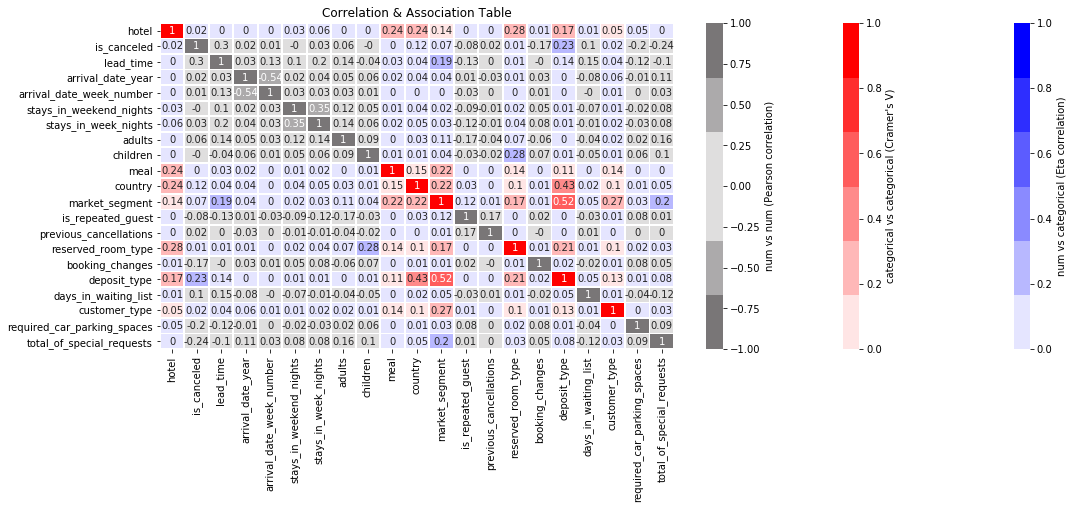

In [12]:
matrix_corr = np.around(matrix_corr, 2)

pd_matrix = pd.DataFrame(matrix_corr)
pd_matrix.columns = df.columns
pd_matrix.set_index(df.columns, inplace=True)

mask_num = np.where(matrix_mask == 1, False, True)
mask_cat = np.where(matrix_mask == 2, False, True)
mask_mixed = np.where(matrix_mask == 3, False, True)

cm_blue = sns.light_palette("blue", as_cmap=False)
cm_red = sns.light_palette("red", as_cmap=False)
cm_grey = sns.diverging_palette(h_neg=1, h_pos=1, s=1, as_cmap=False)

plt.figure(figsize = (18,6))
plt.title('Correlation & Association Table')

sns.heatmap(pd_matrix, annot=True, mask=mask_mixed, cmap=cm_blue, vmax=1, vmin=0, linewidths =.7, cbar_kws={'label': "num vs categorical (Eta correlation)"})
sns.heatmap(pd_matrix, annot=True, mask=mask_cat, cmap=cm_red, vmax=1, vmin=0, linewidths =.7, cbar_kws={'label': "categorical vs categorical (Cramer's V)"})
sns.heatmap(pd_matrix, annot=True, mask=mask_num, cmap=cm_grey, vmax=1, vmin=-1, linewidths =.7, cbar_kws={'label': "num vs num (Pearson correlation)"})

- We do not see any high or interesting values in the table (we were especially interested in absolute values greater or equal than 0.75). Therefore, we do not delete any column in this step

### - Handling Categorical features: Mean Encoding

- We are going to treat the 7 categorical features that we have: **hotel**, **meal**, **country**, **market_segment**, **reserved_room_type**, **deposit_type** and **customer_type**. For the moment we consider them as **ordinal categorical features**

- We are in a binary classification: we can encode the categorical features using **mean encoding with CV loops for regularization**

In [13]:
cat_cols = df.columns[df.dtypes==object].tolist()

X = df.copy()
y = df['is_canceled'].values

# Splitting into train and test
# It returns dataframes with proper indices
# Observe that X_train_orig will contain a copy of y
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=345)

In [14]:
# Just to avoid an annoying warning
pd.options.mode.chained_assignment = None 

cat_cols = df.columns[df.dtypes == object].tolist() #colums that we want to encode
global_train_mean = X_train_orig['is_canceled'].mean()

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

for tr_ind, val_ind in skf.split(X_train_orig, y_train_orig):
    print(tr_ind, val_ind)      #tr_ind and val_ind are the positions of the rows
    X_tr, X_val = X_train_orig.iloc[tr_ind], X_train_orig.iloc[val_ind]
   
    for col in cat_cols:
        means = X_val[col].map(X_tr.groupby(col)['is_canceled'].mean())
        X_train_orig.loc[X_train_orig.index[val_ind], col+'_new'] = means 

[    3     4     5 ... 95508 95509 95511] [    0     1     2 ... 95497 95502 95510]
[    0     1     2 ... 95508 95509 95510] [   21    28    43 ... 95504 95507 95511]
[    0     1     2 ... 95507 95510 95511] [    3     5    13 ... 95505 95508 95509]
[    0     1     2 ... 95509 95510 95511] [    4     6     9 ... 95500 95501 95506]
[    0     1     2 ... 95509 95510 95511] [    7     8    10 ... 95491 95493 95503]


In [15]:
for col in cat_cols:
    X_train_orig[col+'_new'].fillna(global_train_mean, inplace = True)
    X_test_orig[col] = X_test_orig[col].map(X_train_orig.groupby(col)[col+'_new'].mean())
    X_test_orig[col].fillna(global_train_mean, inplace=True)

In [16]:
X_train_orig.drop(cat_cols, axis = 1, inplace=True)

# Feature Importances and Selection

We are goint to use a **Recursive Features Elimination** (with Random Forest) to study the importances of our features

In [17]:
X_train_orig.var()

is_canceled                        0.233210
lead_time                      10088.569539
arrival_date_year                  0.501792
arrival_date_week_number          46.378141
stays_in_weekend_nights            0.820429
stays_in_week_nights               2.333256
adults                             0.225897
children                           0.067257
is_repeated_guest                  0.030973
previous_cancellations             0.003630
booking_changes                    0.248070
days_in_waiting_list               0.029952
required_car_parking_spaces        0.058315
total_of_special_requests          0.514533
hotel_new                          0.004352
meal_new                           0.000045
country_new                        0.028043
market_segment_new                 0.016667
reserved_room_type_new             0.001230
deposit_type_new                   0.054189
customer_type_new                  0.004300
dtype: float64

In [18]:
rfc_model = RandomForestClassifier(random_state=123)

z = X_train_orig.copy()
y = z['is_canceled']
X = z.drop('is_canceled', axis = 1)

rfecv = RFECV(estimator=rfc_model, step=1, cv=StratifiedKFold(5, shuffle=True, random_state=123), 
              scoring='accuracy', n_jobs = -1, verbose = 1)

rfecv.fit(X, y)

Fitting estimator with 20 features.
Fitting estimator with 19 features.


RFECV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=123,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=1)

Optimal number of features : 18
Best features : Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'booking_changes', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_new', 'meal_new', 'country_new',
       'market_segment_new', 'reserved_room_type_new', 'deposit_type_new',
       'customer_type_new'],
      dtype='object')
Original features : Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_new', 'meal_new', 'country_new',
       'market_segment_new', 'reserved_room_type_new', 'deposit_type_new',
       'customer_type_new'],
      dtype='object')


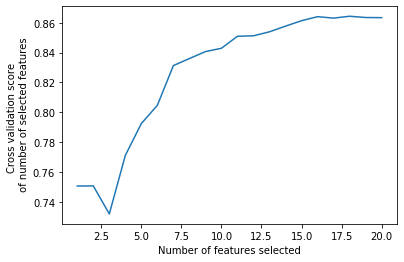

In [19]:
print("Optimal number of features : %d" % rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [20]:
print(rfecv.grid_scores_)
print(rfecv.ranking_)
print(rfecv.n_features_)
print(X.columns[rfecv.support_])
rfecv.estimator_.feature_importances_

[0.75048163 0.75056542 0.73178245 0.7710131  0.79237169 0.80461098
 0.83124635 0.83595779 0.84061687 0.84284698 0.85089831 0.85121244
 0.85389273 0.85768278 0.86133681 0.86402757 0.86306436 0.86432074
 0.86347267 0.86337842]
[1 1 1 1 1 1 1 1 3 1 2 1 1 1 1 1 1 1 1 1]
18
Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'booking_changes', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_new', 'meal_new', 'country_new',
       'market_segment_new', 'reserved_room_type_new', 'deposit_type_new',
       'customer_type_new'],
      dtype='object')


array([0.17583127, 0.03163711, 0.09232816, 0.03298346, 0.05147795,
       0.01922776, 0.00802173, 0.00348745, 0.02353023, 0.02536732,
       0.05427775, 0.02517611, 0.02666717, 0.12811995, 0.0845585 ,
       0.03316053, 0.14169866, 0.04244888])

In [21]:
# We save rfecv to our directory
filename = "Models/feature_importances/rfecv.sav"
pickle.dump(rfecv, open(filename, 'wb'))

In [22]:
num_feature = rfecv.n_features_
tab_general = pd.DataFrame ({ 'rank': rfecv.ranking_ , 'variables': X.columns.tolist()})
tab_rank = tab_general.copy()
tab_importances = tab_general.copy()

tab_rank = pd.DataFrame(tab_general.groupby('rank')['variables'].apply(list))
tab_rank['score']= rfecv.grid_scores_[num_feature-1 : len(rfecv.grid_scores_)]

In [23]:
tab_rank

,variables,score
rank,,
1,"[lead_time, arrival_date_year, arrival_date_we...",0.864321
2,[days_in_waiting_list],0.863473
3,[previous_cancellations],0.863378


In [24]:
tab_importances = tab_importances[tab_importances['rank']==1].drop('rank', axis = 1)
tab_importances['importances'] = rfecv.estimator_.feature_importances_
tab_importances.sort_values(by = 'importances', ascending = False, inplace = True)
tab_importances.reset_index(drop=True, inplace=True)

In [25]:
tab_importances

,variables,importances
0,lead_time,0.175831
1,deposit_type_new,0.141699
2,country_new,0.128120
3,arrival_date_week_number,0.092328
4,market_segment_new,0.084559
5,total_of_special_requests,0.054278
6,stays_in_week_nights,0.051478
7,customer_type_new,0.042449
8,reserved_room_type_new,0.033161
9,stays_in_weekend_nights,0.032983


- It is evident from our **tab_importances** that lead_time, deposit_type and country are the most relevant features.
- At the same time the scores of the model does not change a lot while we eliminate the least relevant features. However, to avoid taking too much complexity in the model we decide to keep only the features suggested by RFECV

In [26]:
tab_rank[tab_rank.index == 1]['variables']
important_features_train = [x for x in tab_rank[tab_rank.index == 1]['variables']][0]
X_train_orig = X_train_orig[[x for x in important_features_train]]

In [27]:
important_features_test = [x.replace("_new", "") for x in important_features_train]
X_test_orig = X_test_orig[[x for x in important_features_test]]

### - Feature scaling

In [28]:
# min-max transformation
# to mantain same distribution
min_max = MinMaxScaler()
X_train_scaled = X_train_orig.copy()
X_test_scaled = X_test_orig.copy()

X_train_scaled[X_train_scaled.columns] = min_max.fit_transform(X_train_orig[X_train_orig.columns])
X_test_scaled[X_test_scaled.columns] = min_max.transform(X_test_orig[X_test_orig.columns])


# MODELLING

- We create two models using **XGBoost** and **Logistic Regression**. At the very beginning we use the default hyperparameters just to get a general idea. After that, we will perform a hyperparameters tuning

In [29]:
# We set the two algorithms
xgb_clf = xgb.XGBClassifier()
logit = LogisticRegression(solver='liblinear')

In [30]:
# We get rid of then "_new" string in the scaled DataFrame
X_train_scaled.columns = X_train_scaled.columns.str.replace("_new", "")

## - XGBoost

In [31]:
xgb_model_default = classifier_gridCV(X_train_scaled, y_train_orig, xgb.XGBClassifier(),
                                     X_test_scaled, y_test_orig, model_name = "xg_boost")


The best parameters of grid are:  {} 
The best estimator is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
The results on the test are: 
Precision = 0.8505226534573631
Recall = 0.8398055538414696
Accuracy = 0.85706508082754


Text(0.5, 1, 'Confusion Matrix')

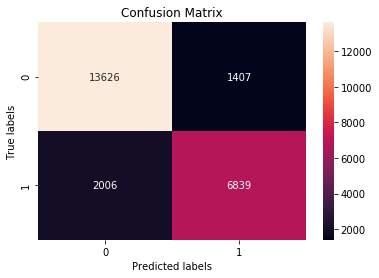

In [32]:
# Looking at the confusion matrix on the test
pred_xgb = xgb_model_default.predict(X_test_scaled)
cm_xgb=metrics.confusion_matrix(y_test_orig, pred_xgb)
classes_xgb = xgb_model_default.classes_

ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='d')

# Labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [33]:
# Looking at the Cohen score on the test
cohen_score_xgb = cohen_kappa_score(y_test_orig, pred_xgb)
cohen_score_xgb

0.6892174913477116

- The Cohen score is quite good: it is clearly above 0.5 but it does not reach 0.8

## - Logistic Regression

In [34]:
logistic_model_default = classifier_gridCV(X_train_scaled, y_train_orig, logit,
                                         X_test_scaled, y_test_orig, model_name = "logistic_regression")


The best parameters of grid are:  {} 
The best estimator is:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
The results on the test are: 
Precision = 0.7886281099985111
Recall = 0.7424730713966865
Accuracy = 0.7864561521065416


Text(0.5, 1, 'Confusion Matrix')

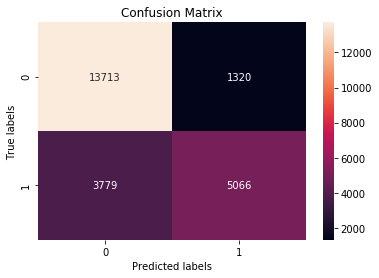

In [35]:
# Looking at the confusion matrix on the test
pred_logistic = logistic_model_default.predict(X_test_scaled)
cm_logistic=metrics.confusion_matrix(y_test_orig, pred_logistic)
classes_logistic = logistic_model_default.classes_

ax = plt.subplot()
sns.heatmap(cm_logistic, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells

# Labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [36]:
# Looking at the Cohen score on the test
cohen_score_logistic = cohen_kappa_score(y_test_orig, pred_logistic)
cohen_score_logistic

0.5143780043926575

- The Cohen score is not satisfactory for us: it is about 0.5

## XGBoost vs Logistic Regression: ROC Curve

We try to compare the two models using the ROC Curve

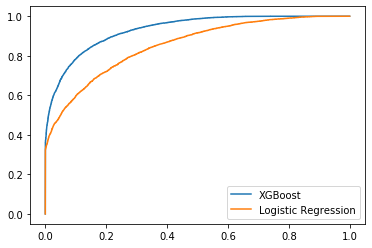

The AUC for xgboost is: 0.9327864001627172
The AUC for the logistic regression is: 0.853475404797217


In [37]:
probabilities_xgb = xgb_model_default.predict_proba(X_test_scaled)[:,1]
probabilities_logistic = logistic_model_default.predict_proba(X_test_scaled)[:,1]

fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test_orig, probabilities_xgb, pos_label=1)
fpr_logistic, tpr_logistic, thresholds_logistic = metrics.roc_curve(y_test_orig, probabilities_logistic, pos_label=1)

# Print ROC curve
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot(fpr_logistic, tpr_logistic, label="Logistic Regression")
plt.legend()
plt.show()

# Print AUC
auc_xgb = np.trapz(tpr_xgb, fpr_xgb)
print('The AUC for xgboost is:', auc_xgb)

auc_logistic = np.trapz(tpr_logistic, fpr_logistic)
print('The AUC for the logistic regression is:', auc_logistic)


 - Both the AUC scores are very good, especially the one for xgboost
 - Considering all the metrics, we consider the xgboost model much more robust and reliable. For these reasons and given our computational resources, **we decid to perform the hyperparameter tuning only on the XGBoost algorithm** 

# XGBoost: Hyperparameters Tuning

## Coarse to fine approach (using Hyperopt)

The approach that we are going to use is the following:
- We supply a distribution space (uniform) for each hyperparameter that we want to tune
- We use an optimizer (TPE) to minimize the loss (i.e. 1-accuracy)
- Analyzing the results, we will find the best perforiming regions for the hyperparameters
- Finally, we perform a GridSearchCV on the most interesting regions

**Note**: for computational reasons, we take at most 75 estimators

In [38]:
space = {
    'max_depth': hp.uniform ('max_depth', 5, 20),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),
    'n_estimators': hp.uniform('n_estimators', 30, 75)
}

def objective(params):
    params = {
        'max_depth': [int(params['max_depth'])],
        'learning_rate': [params['learning_rate']],
        'n_estimators': [int(params['n_estimators'])]
    }
    grid = GridSearchCV(xgb.XGBClassifier(), params, scoring='accuracy', 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, 
                                            random_state=42), 
                        n_jobs=-1)
    model = grid.fit(X_train_scaled, y_train_orig)
    mean_score = model.cv_results_["mean_test_score"][0]
    loss = 1- mean_score
    return loss

trials = Trials()

best_result = fmin(
             fn = objective,
             space = space,
             trials = trials,
             max_evals = 50,
             rstate = np.random.RandomState(42),
             algo = tpe.suggest)



100%|██████████| 50/50 [38:13<00:00, 45.88s/trial, best loss: 0.13811876053193894]


In [ ]:
print("The accuracy is: ")

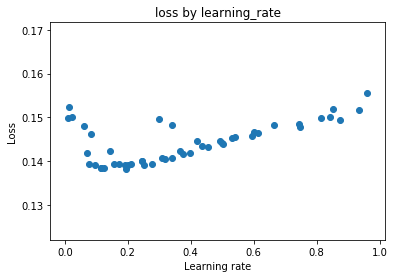

In [39]:
learning_rates = [t['misc']['vals']['learning_rate'] for t in trials.trials]
loss = [t['result']['loss'] for t in trials.trials]
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('loss by learning_rate')

plt.scatter(learning_rates, loss)

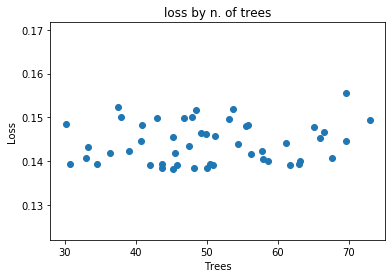

In [40]:
trees = [t['misc']['vals']['n_estimators'] for t in trials.trials]
loss = [t['result']['loss'] for t in trials.trials]
plt.xlabel('Trees')
plt.ylabel('Loss')
plt.title('loss by n. of trees')

plt.scatter(trees, loss)

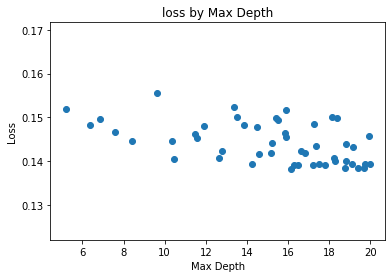

In [41]:
depth = [t['misc']['vals']['max_depth'] for t in trials.trials]
loss = [t['result']['loss'] for t in trials.trials]
plt.xlabel('Max Depth')
plt.ylabel('Loss')
plt.title('loss by Max Depth')

plt.scatter(depth, loss)

In [42]:
best_parameters_hp = pd.DataFrame({'max_depth':depth, 'n_estimators':trees, 
                                   'learning_rate':learning_rates, 'loss':loss}).sort_values(by='loss', ascending= True)

In [43]:
print(best_parameters_hp.iloc[0])

max_depth        [16.157652158213793]
n_estimators      [45.29561596109918]
learning_rate    [0.1941300461673145]
loss                         0.138119
Name: 37, dtype: object


The accuracy is about 86.19%, so it improved by 0.5%.
Having just 50 points, the patterns are not so clear. However, looking at the charts, it is not so difficult to deduce the following properties:
- the learning rate should be in the interval [0.1, 0.2]
- the max_depth should be greater or equal than 13
- the n_estimators should be greater than 45, since 45 was the best parameters and adding more trees in general improve the performance

In [44]:
filename = "Models/saved_models/xgboost_hyperopt.sav"
pickle.dump(best_result, open(filename, 'wb'))

### GridSearchCV with the most promising parameters

In [45]:
parameters = {
    'learning_rate':[0.1, 0.13, 0.15, 0.17, 0.2],
    'n_estimators':[45, 55, 65, 75, 85, 95],
    'max_depth':[13, 14, 15, 16, 17]
    
}

In [46]:
xgb_model_tuned = classifier_gridCV(X_train_scaled, y_train_orig, xgb.XGBClassifier(),
                                     X_test_scaled, y_test_orig, params=parameters,
                                    model_name = "xg_boost_tuned")

The best parameters of grid are:  {'learning_rate': 0.15, 'max_depth': 15, 'n_estimators': 85} 
The best estimator is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=85, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
The results on the test are: 
Precision = 0.8606840191544529
Recall = 0.8515741268963322
Accuracy = 0.8669905352207052


- We improved the accuracy by 0.5%. It seems our strategy took us on the right path. We check the Cohen score and the ROC curve too

Text(0.5, 1, 'Confusion Matrix')

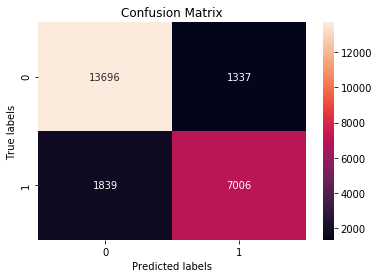

In [47]:
# Looking at the confusion matrix on the test
pred_xgb_tuned = xgb_model_tuned.predict(X_test_scaled)
cm_xgb_tuned=metrics.confusion_matrix(y_test_orig, pred_xgb_tuned)
classes_logistic = xgb_model_tuned.classes_

ax = plt.subplot()
sns.heatmap(cm_xgb_tuned, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [48]:
# Looking at the cohen score on the test
cohen_score_xgb_tuned = cohen_kappa_score(y_test_orig, pred_xgb_tuned)
cohen_score_xgb_tuned

0.7114588139164824

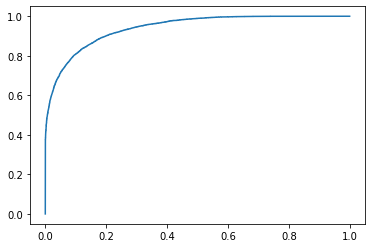

The AUC is: 0.9403767073282945


In [49]:
probabilities_xgb_tuned = xgb_model_tuned.predict_proba(X_test_scaled)[:,1]
fpr_xgb_tuned, tpr_xgb_tuned, thresholds_xgb_tuned = metrics.roc_curve(y_test_orig, probabilities_xgb_tuned,
                                                                       pos_label=1)


# Print ROC curve
plt.plot(fpr_xgb_tuned, tpr_xgb_tuned)
plt.show()

# Print AUC
auc_xgb_tuned = np.trapz(tpr_xgb_tuned, fpr_xgb_tuned)
print('The AUC is:', auc_xgb_tuned)


- Both the metrics improved, so in general we can claim that our hyperparameter strategy worked 

In [50]:
filename = "Models/saved_models/xgboost_tuned.sav"
pickle.dump(xgb_model_tuned, open(filename, 'wb'))

# THE END